## Домашнее задание к занятию "Алгоритмы классификации: линейные методы, логистическая регрессия и SVM"

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

Загрузим данные из файла:

In [3]:
df = pd.read_csv('adult.csv',na_values='?')

In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Удалим незначимое поле fnlwgt

In [5]:
df.drop(['fnlwgt'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
age                48842 non-null int64
workclass          46043 non-null object
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         46033 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     47985 non-null object
income             48842 non-null object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


Данный dataset содержит три категории с пропущенными значениями: workclass, occupation, native-country        

Рассмотрим сколько уникальных значений содержится в каждой категориальной фичи, если не очень много переведем их фичи методом get_dummies

In [6]:
df.workclass.value_counts(dropna=False)

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
NaN                  2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

Заполним пропущенные значения наиболее часто встречающимся значением Private

In [6]:
df['workclass'] = df['workclass'].fillna(value='Private')

In [8]:
df.education.value_counts(dropna=False)

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

In [9]:
df.occupation.value_counts(dropna=False)

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
NaN                  2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [7]:
df.columns=['age', 'workclass', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income']

In [11]:
df.marital_status.value_counts(dropna=False)

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital_status, dtype: int64

In [12]:
df.relationship.value_counts(dropna=False)

Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: relationship, dtype: int64

In [13]:
df.race.value_counts(dropna=False)

White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64

In [14]:
df.gender.value_counts(dropna=False)

Male      32650
Female    16192
Name: gender, dtype: int64

In [15]:
df.native_country.value_counts(dropna=False)

United-States                 43832
Mexico                          951
NaN                             857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                        

Заполним пропущенные значения и наименее часто встречающиеся значением Other

In [8]:
df['country']=df.apply(lambda row: row.native_country if row.native_country in ['United-States', 
       'Mexico', 'Philippines', 'Germany', 'Puerto-Rico',
       'Canada', 'El-Salvador', 'India', 'Cuba', 'England', 'China', 'South',
       'Jamaica', 'Italy', 'Dominican-Republic'] else 'Other',axis=1)
df.drop('native_country',axis=1,inplace=True)

In [17]:
df.country.value_counts()

United-States         43832
Other                  2070
Mexico                  951
Philippines             295
Germany                 206
Puerto-Rico             184
Canada                  182
El-Salvador             155
India                   151
Cuba                    138
England                 127
China                   122
South                   115
Jamaica                 106
Italy                   105
Dominican-Republic      103
Name: country, dtype: int64

In [9]:
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df.drop(each,inplace=True,axis=1)
    return df

In [10]:
X=get_one_hot(df,['gender','race','relationship','marital_status','country','workclass','education'])
Y=X.income
X.drop(['occupation','income'],axis=1,inplace=True)


In [20]:
X.head()

,age,educational_num,capital_gain,capital_loss,hours_per_week,gender_Female,gender_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,...,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
0,25,7,0,0,40,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,38,9,0,0,50,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,28,12,0,0,40,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,44,10,7688,0,40,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,18,10,0,0,30,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
X.describe()

,age,educational_num,capital_gain,capital_loss,hours_per_week,gender_Female,gender_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,...,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.331518,0.668482,0.009623,0.031100,0.095922,...,0.015478,0.032779,0.042197,0.164305,0.012162,0.323164,0.054400,0.001699,0.017075,0.222718
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.470764,0.470764,0.097624,0.173591,0.294487,...,0.123447,0.178060,0.201041,0.370556,0.109608,0.467690,0.226807,0.041189,0.129554,0.416075
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Сделаем масштабирование для всех фичей, т.к. логитическая регрессия чувствительна к различным масштабам.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

D:\Netology\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Netology\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
X_scaled.head()

,age,educational_num,capital_gain,capital_loss,hours_per_week,gender_Female,gender_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,...,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
0,-0.995129,-1.197259,-0.144804,-0.217127,-0.034087,-0.70422,0.70422,-0.098572,-0.179161,3.070047,...,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,-0.535289
1,-0.046942,-0.419335,-0.144804,-0.217127,0.772930,-0.70422,0.70422,-0.098572,-0.179161,-0.325728,...,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,1.447204,-0.239853,-0.041258,-0.131803,-0.535289
2,-0.776316,0.747550,-0.144804,-0.217127,-0.034087,-0.70422,0.70422,-0.098572,-0.179161,-0.325728,...,-0.125387,5.432051,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,-0.535289
3,0.390683,-0.030373,0.886874,-0.217127,-0.034087,-0.70422,0.70422,-0.098572,-0.179161,3.070047,...,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,1.868149
4,-1.505691,-0.030373,-0.144804,-0.217127,-0.841104,1.42001,-1.42001,-0.098572,-0.179161,-0.325728,...,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,1.868149


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [15]:
le=LabelEncoder()
le.fit(Y)

LabelEncoder()

In [16]:
Y = le.transform(Y)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2)

In [18]:
LogReg = LogisticRegression()

In [19]:
LogReg.fit(x_train,y_train)

D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
predictions_proba = LogReg.predict_proba(x_test)
predictions = LogReg.predict(x_test)

In [63]:
from sklearn.metrics import precision_recall_curve, accuracy_score, average_precision_score, roc_curve, roc_auc_score, auc

In [45]:
pr, re, thres = precision_recall_curve(y_test, predictions_proba[:, 1] )

In [46]:
for line in zip( predictions_proba[:, 1], y_test ):
    print( line )

(0.24811900912214357, 1)
(0.0073923336409657606, 0)
(0.12360477685632251, 0)
(0.20856897812256625, 0)
(0.00911512738110935, 0)
(0.0361549345468535, 0)
(0.06876199355556331, 0)
(0.21165127128856176, 1)
(0.0029321167679415313, 0)
(0.38240396750689465, 1)
(0.8155429296291922, 1)
(0.03724282918617348, 0)
(0.347464295366262, 1)
(0.3216899040093064, 1)
(0.25621611772288694, 1)
(0.140446743996574, 0)
(0.0041564149810391655, 0)
(0.26501649858293025, 0)
(0.3699425457970076, 1)
(0.3883578644064732, 1)
(0.6590674796697852, 1)
(0.14998486011033726, 0)
(0.527442421327745, 0)
(0.5737514135379015, 0)
(0.0004053180834332172, 0)
(0.021333190370696566, 0)
(0.0037116839787978413, 0)
(0.03402158047455171, 0)
(0.013144466015802872, 0)
(0.04609485779062092, 0)
(0.1804415969892854, 0)
(0.8972841942939186, 1)
(0.2635815000081518, 0)
(0.1482531145553866, 0)
(0.14850092296868375, 0)
(0.005561689414599624, 0)
(0.7775336412643734, 1)
(0.004982793901104791, 0)
(0.001368803226951164, 0)
(0.002937304874832188, 1)
(0

(0.3200701285294818, 1)
(0.005346745792491023, 0)
(0.2962313986980602, 1)
(0.6661362750135573, 1)
(0.7637111735475628, 1)
(0.04044780942600855, 0)
(0.08457442634109565, 0)
(0.019371897278862772, 0)
(0.015504228997319703, 0)
(0.4571512353956893, 0)
(0.2040003888620204, 1)
(0.07898571032651713, 0)
(0.0067246975244731584, 0)
(0.04414978442018819, 0)
(0.20352251583367773, 0)
(0.031819684613654274, 0)
(0.6792460092259308, 0)
(0.0015005875724429624, 0)
(0.14152127147690718, 1)
(0.8527298777046934, 1)
(0.5361344201741955, 1)
(0.15799993658467526, 0)
(0.009236902582216032, 0)
(0.005801802517161262, 0)
(0.8202255101239695, 1)
(0.013728345780895233, 0)
(0.09209389876098219, 0)
(0.09455943497016704, 0)
(0.13598696078146846, 0)
(0.06122883841303788, 0)
(0.6564452971289152, 0)
(0.0286287095116254, 0)
(0.029235951326306492, 0)
(0.001561155120728871, 0)
(0.026942148531818484, 0)
(0.3135417049126935, 0)
(0.031234908648365003, 0)
(0.07302568455224273, 0)
(0.42078451459492766, 1)
(0.013333557389150544, 

(0.022859734830583952, 0)
(0.17369923304149895, 0)
(0.5076511503394175, 1)
(0.8770917995993345, 1)
(0.27400779469844216, 1)
(0.11833900451555583, 0)
(0.003807128352351136, 0)
(0.04072155089255351, 0)
(0.6443150766270642, 1)
(0.010781297985434972, 0)
(0.651749146021508, 0)
(0.1200891242906138, 0)
(0.3118059633528549, 1)
(0.02644127358470767, 0)
(0.0005244188423385471, 0)
(0.2303223408578062, 0)
(0.04475297932085595, 0)
(0.03399934120782148, 0)
(0.017421601090272056, 0)
(0.056419087132939666, 0)
(0.9351510392991581, 1)
(0.6700310897063152, 1)
(0.2623998620418279, 0)
(0.3234548065646836, 0)
(0.0015362657407162637, 0)
(0.20332447256071584, 0)
(0.7862872526311453, 1)
(0.18316239097242668, 0)
(0.019034569258112966, 0)
(0.05564131650777272, 0)
(0.2057625334045441, 0)
(0.048211551124501775, 0)
(0.5950599128102603, 1)
(0.006445176038375927, 0)
(0.4209043454754409, 1)
(0.24215737315049166, 0)
(0.07554444594321301, 0)
(0.7306637980204285, 1)
(0.021032111955069776, 0)
(0.7503306760484022, 1)
(0.06

(0.053930243456712934, 0)
(0.028556821831450575, 0)
(0.32661108402097055, 0)
(0.4686858511117224, 1)
(0.02258560806871541, 0)
(0.345412383216179, 0)
(0.060880578527223346, 0)
(0.18719921278441534, 0)
(0.4702310585564869, 1)
(0.5792132254366581, 1)
(0.00870806427189428, 0)
(0.519060817272171, 1)
(0.025019924184326976, 0)
(0.5872969908509273, 1)
(0.02919720676341571, 0)
(0.06731400105343528, 0)
(0.6855812263749492, 0)
(0.7299772968293488, 0)
(0.37914373628887804, 0)
(0.865679058282105, 1)
(0.3361765834487608, 0)
(0.12895914458779006, 0)
(0.03858329220634817, 0)
(0.4812652831944563, 0)
(0.9827877174848211, 1)
(0.3358105047401094, 0)
(0.2339830453832294, 0)
(0.0016150117903574238, 0)
(0.5418088289944614, 1)
(0.0017017004254166813, 0)
(0.003120236743353025, 0)
(0.9999999999999878, 1)
(0.01825986131128139, 0)
(0.02160891012611491, 0)
(0.03685490115102195, 0)
(0.028940046346344565, 0)
(0.08249383483534052, 0)
(0.02469254633812427, 0)
(0.021384703535771314, 0)
(0.0005192044495109262, 0)
(0.175

(0.004048263224915609, 0)
(0.45525096864884673, 1)
(0.02793007842547238, 0)
(0.18461658138812298, 1)
(0.1023853746676609, 0)
(0.11614636889611826, 0)
(0.5974031006254574, 1)
(0.0025491798091818126, 0)
(0.1406133282990981, 0)
(0.08070855548766659, 0)
(0.004766218671814727, 0)
(0.7680120726155089, 1)
(0.3626908960214531, 0)
(0.09636518307927704, 1)
(0.03595011964313611, 0)
(0.08951661412499431, 0)
(0.8283287209174587, 1)
(0.7319389518138711, 1)
(0.02200737657527875, 0)
(0.8314541832532621, 1)
(0.003817858499511012, 0)
(0.0026615170485576895, 0)
(0.012376422224314567, 0)
(0.44694905418478903, 0)
(0.47924748259900557, 1)
(0.2229641927248577, 0)
(0.16442851385932952, 0)
(0.05467277514533208, 0)
(0.4329073407901527, 1)
(0.7276558941314236, 1)
(0.030516306871249704, 0)
(0.00875198490351098, 0)
(0.21869919701416757, 1)
(0.005839011399957088, 0)
(0.36590981322410465, 0)
(0.03879282382974802, 0)
(0.007226636859609848, 0)
(0.4285781539521426, 0)
(0.06469380198613914, 0)
(0.6616455832402046, 0)
(0

(0.23353625694388636, 1)
(0.0009961002396890151, 0)
(0.028842288961910625, 0)
(0.039271264547414426, 0)
(0.004647851189548863, 0)
(0.6512093233767353, 1)
(0.004612882707518122, 0)
(0.05299622574740827, 0)
(0.004350038808560009, 0)
(0.43852205771151787, 0)
(0.05775157917520455, 0)
(0.5866951038010191, 1)
(0.005001386220091246, 0)
(0.20825802453283723, 0)
(0.8193475566052102, 1)
(0.7141298728641894, 1)
(0.8214527625937643, 1)
(0.35581083659844964, 0)
(0.045079077498499924, 0)
(0.20381719848050175, 0)
(0.20664820378253984, 0)
(0.3097297268105156, 0)
(0.9974056056258412, 1)
(0.20381719848050175, 1)
(0.006043871928748756, 0)
(0.3935813791356887, 0)
(0.08782936463374247, 0)
(0.3720737250174255, 1)
(0.0017409402071663317, 0)
(0.010867993331234333, 0)
(0.11062583391370219, 0)
(0.1684128767357593, 0)
(0.5124464615939175, 1)
(0.0007920938227632037, 0)
(0.13648359633719512, 0)
(0.0017409402071663317, 0)
(0.04597350483370803, 0)
(0.005436801183544361, 0)
(0.2525111151970507, 0)
(0.0985223154424080

(0.1618236408921788, 0)
(0.014223814798002212, 0)
(0.34147442803176453, 1)
(0.0007367176736654434, 0)
(0.017292414927394754, 0)
(0.003475926682419205, 0)
(0.02094475373239017, 0)
(0.21334408925227166, 0)
(0.998869879934255, 1)
(0.7691204390008034, 1)
(0.0010880742967107997, 0)
(0.011800963695893682, 0)
(0.021378420235704836, 0)
(0.006712712392137887, 0)
(0.0002643102659896509, 0)
(0.32507188127588954, 1)
(0.9157432656835321, 1)
(0.24558610764158506, 0)
(0.25480217671057503, 0)
(0.5810270173667348, 0)
(0.02091619613974027, 0)
(0.0025522892875899194, 0)
(0.22695498807661876, 0)
(0.025552808558008705, 0)
(0.4574116108208072, 1)
(0.011125806981055303, 0)
(0.36895398913552224, 0)
(0.0034142733179055823, 0)
(0.2420560464408951, 0)
(0.14339564767474378, 0)
(0.1459983788708453, 0)
(0.09955449170638589, 0)
(0.7795898732093234, 1)
(0.3151208547014002, 0)
(0.8559080767138902, 1)
(0.03942461179429879, 0)
(0.003984124917085089, 0)
(0.0994886388416722, 0)
(0.2809810390567739, 1)
(0.00588221179427601

(0.0109741551892881, 0)
(0.06461026926523857, 0)
(0.02305364225823019, 0)
(0.01755121508845262, 0)
(0.33009038384044004, 1)
(0.1448171710524048, 0)
(0.29570109517530263, 0)
(0.11668165471507139, 0)
(0.07245509365362209, 0)
(0.005801802517161262, 0)
(0.05472332900408822, 0)
(0.036120733982205465, 0)
(0.005561689414599624, 0)
(0.03986042539205851, 0)
(0.3637934851866459, 1)
(0.930998446834486, 1)
(0.1011722838063691, 0)
(0.24418481693560895, 0)
(0.0073923336409657606, 0)
(0.05803776690002503, 0)
(0.9600405929157716, 1)
(0.008860500015422103, 0)
(0.5981940080357858, 0)
(0.32588198808727825, 0)
(0.44279881788249825, 0)
(0.9966635082552752, 1)
(0.04136309324533222, 0)
(0.017742014702790188, 0)
(0.11710643282687042, 0)
(0.002990512299886372, 0)
(0.40415361250186616, 0)
(0.41367720928835383, 0)
(0.27287924582738515, 1)
(0.8908985753614085, 1)
(0.01769391686689381, 0)
(0.003349959643900325, 0)
(0.3266931365443952, 0)
(0.3438307429193574, 1)
(0.01499843626833476, 0)
(0.10432365649990792, 0)
(0.

In [47]:
LogReg.score(x_test, y_test)

0.8496263691268298

In [48]:
accuracy_score(y_test, predictions)

0.8496263691268298

In [52]:
average_precision_score(y_test, predictions )

0.5470090792886222

In [55]:
fpr, tpr, thres = roc_curve( y_test, predictions )

Text(0,0.5,'True Positive Rate')

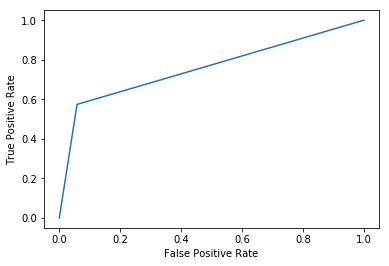

In [59]:
plt.plot( fpr, tpr )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [62]:
roc_auc_score( y_test, predictions)

0.7579275282255324

In [64]:
auc( fpr, tpr )

0.7579275282255324

In [65]:
from sklearn.model_selection import GridSearchCV

In [68]:
LogisticRegression?

In [73]:
grid ={"penalty": ['l1','l2'],"C":[0.00001,0.0001,0.001,0.01,0.1,1]}
model_grid = GridSearchCV(LogisticRegression(),grid,cv=5)

In [74]:
model_grid.fit(x_train,y_train)

D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
model_grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [77]:
LogReg = LogisticRegression(penalty='l2',C=0.1)
LogReg.fit(x_train,y_train)
predictions = LogReg.predict(x_test)

D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
fpr, tpr, thres = roc_curve( y_test, predictions )

In [79]:
roc_auc_score( y_test, predictions)

0.7571102008859327